Testing the stella package to look for flares. 20200917 tensorflow not working

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
"""eg_uma_fits= ['/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2019226182529-s0015-0000000416538823-0151-s/tess2019226182529-s0015-0000000416538823-0151-s_lc.fits',
'/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2020049080258-s0022-0000000416538823-0174-s/tess2020049080258-s0022-0000000416538823-0174-s_lc.fits']


fitter = fitting.LevMarLSQFitter()




for tessfits in eg_uma_fits:
    data = fits.getdata(tessfits, 1)
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    t, f, e = t[q==0], f[q==0], e[q==0]
    lc = lk.LightCurve(time=t, flux=f, flux_err=e).flatten(window_length=1001)#remove_outliers(sigma=5).
    lc = lc.remove_nans()
  #  lc.flux -= 1
   # lc.flux  *= 100
    #lc.flux_err *= 100
    plt.scatter(lc.time,lc.flux, s=5)
    plt.show()"""

"eg_uma_fits= ['/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2019226182529-s0015-0000000416538823-0151-s/tess2019226182529-s0015-0000000416538823-0151-s_lc.fits',\n'/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2020049080258-s0022-0000000416538823-0174-s/tess2020049080258-s0022-0000000416538823-0174-s_lc.fits']\n\n\nfitter = fitting.LevMarLSQFitter()\n\n\n\n\nfor tessfits in eg_uma_fits:\n    data = fits.getdata(tessfits, 1)\n    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']\n    t, f, e = t[q==0], f[q==0], e[q==0]\n    lc = lk.LightCurve(time=t, flux=f, flux_err=e).flatten(window_length=1001)#remove_outliers(sigma=5).\n    lc = lc.remove_nans()\n  #  lc.flux -= 1\n   # lc.flux  *= 100\n    #lc.flux_err *= 100\n    plt.scatter(lc.time,lc.flux, s=5)\n    plt.show()"

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


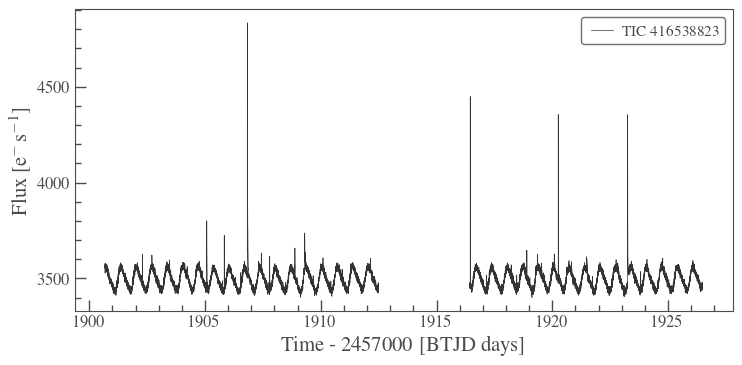

In [3]:
from lightkurve.search import search_lightcurvefile

lc = search_lightcurvefile(target='tic416538823', mission='TESS', sector=22)
lc = lc.download().PDCSAP_FLUX
lc.plot()

In [4]:
lc=lc.remove_nans()

In [5]:
import stella

ModuleNotFoundError: No module named 'stella'

In [ ]:
MODEL_DIR = '/media/david/5tb_storage1/stella/models/run01/'
MODELS = [os.path.join(MODEL_DIR,i) for i in
          os.listdir(MODEL_DIR) if i.endswith('.h5')]
print(MODELS)

In [ ]:
OUT_DIR = '/media/david/5tb_storage1/stella/output/'

In [ ]:
cnn = stella.ConvNN(output_dir=OUT_DIR)

In [ ]:
cnn.predict(modelname=MODELS[0],
            times=lc.time,
            fluxes=lc.flux,
            errs=lc.flux_err)
single_pred = cnn.predictions[0]



In [ ]:
cnn.model.summary()



In [ ]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('TIC {}'.format(lc.targetid));

In [ ]:
preds = np.zeros((len(MODELS),len(cnn.predictions[0])))

for i, model in enumerate(MODELS):
    cnn.predict(modelname=model,
                times=lc.time,
                fluxes=lc.flux,
                errs=lc.flux_err)
    preds[i] = cnn.predictions[0]

avg_pred = np.nanmedian(preds, axis=0)

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,8), nrows=2,
                               sharex=True, sharey=True)
im = ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1)
ax2.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
ax2.set_xlabel('Time [BJD-2457000]')
ax2.set_ylabel('Normalized Flux', y=1.2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Probability')


ax1.set_title('Averaged Predictions')
ax2.set_title('Single Model Predictions')

plt.subplots_adjust(hspace=0.4);



In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,8), nrows=2,
                               sharex=True)
ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1, cmap='Oranges_r', s=6)
ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0]-0.03,
            c=single_pred, vmin=0, vmax=1, cmap='Greys_r', s=6)
ax1.set_ylim(0.93,1.05)
ax2.plot(cnn.predict_time[0], single_pred, 'k')
ax2.plot(cnn.predict_time[0], avg_pred, 'orange')
ax1.set_title('Black = Single Model; Orange = Averaged Models')

plt.xlim(1906, 1908)


In [ ]:
from lightkurve.search import search_lightcurvefile
lc = search_lightcurvefile(target='tic416538823', mission='TESS', sector=22)
lc = lc.download().PDCSAP_FLUX.normalize()
lc.plot()
lc = lc.remove_nans()

In [ ]:
mProt = stella.MeasureProt([lc.targetid], [lc.time], [lc.flux], [lc.flux_err])



In [ ]:
mProt.run_LS()

In [ ]:
mProt.LS_results

In [ ]:
lc.fold(mProt.LS_results['avg_period_days'].data[0]).plot()

In [ ]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0], c=cnn.predictions[0], vmin=0, vmax=1)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');

In [ ]:
ff = stella.FitFlares(id=[lc.targetid],
                      time=[lc.time],
                      flux=[lc.flux],
                      flux_err=[lc.flux_err],
                      predictions=[cnn.predictions[0]])

In [ ]:
ff.identify_flare_peaks(threshold=0.5)

ff.flare_table



In [ ]:
plt.figure(figsize=(14,4))
plt.scatter(ff.time[0], ff.flux[0], c=cnn.predictions[0], s=5)

for tpeak in ff.flare_table['tpeak']:
    plt.vlines(tpeak, 0,2, color='k', alpha=0.5, linewidth=5, zorder=0)

plt.ylim(0.94,1.3)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');


In [ ]:
plt.hist(cnn.predictions[0], bins=10)

In [ ]:
len(cnn.predictions[0][cnn.predictions[0]>0.5])/len(cnn.predictions[0])*100